<a href="https://colab.research.google.com/github/SarahM254/FinPort-Lending-Strategy/blob/main/FinPort_Lending_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The scenario is

Company: “FinPort” — a mid-sized consumer lending portfolio manager.
   
   Objective: decide whether to (A) buy a peer portfolio, or (B) allocate additional capital to originations — using data-driven valuation and forecasts.

**Deliverables / KPIs**

0. Generate the data we need

    a. Columns: date (monthly), loan_id, customer_id, origination_date, loan_amount, interest_rate, term_months, balance, payment, default_flag (0/1), recovery_rate, region, income, credit_score, product
    
    b. Data description: Monthly portfolio dataset for 5 years

1. Portfolio profitability (Net Interest Income, charge-off rate, NIM) — baseline model.

2. Portfolio Valuation (Discounted Cash Flow of expected cash flows) — DCF model.

3. Risk/Uncertainty Assessment (Monte Carlo simulation of portfolio NPV under variable default & interest scenarios).

4. Forecast monthly default rate and monthly net interest income (two independent forecasting approaches).

5. Train/Test split + backtest so predictions are testable later.

In [ ]:
!pip install matplotlib-venn

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
import os
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm


In [2]:
# dataset_generator.py

def generate_portfolio(start='2018-01-01', months=72, n_loans=2000):
    """
    Generate a synthetic loan portfolio dataset with monthly snapshots
    including defaults, payments, balances, and borrower attributes.
    """
    dates = pd.date_range(start, periods=months, freq='MS')
    loans = []

    # Loan-level static attributes
    loan_ids = np.arange(1, n_loans + 1)
    orig_dates = np.random.choice(dates[:24], size=n_loans)  # origination within first 2 years
    loan_amounts = np.round(np.random.lognormal(mean=8.5, sigma=0.6, size=n_loans), -2)
    interest_rates = np.round(np.random.normal(0.12, 0.03, size=n_loans), 4).clip(0.04, 0.35)
    terms = np.random.choice([24, 36, 48, 60], size=n_loans, p=[0.2,0.4,0.3,0.1])
    credit_scores = np.random.randint(520, 820, size=n_loans)
    incomes = np.round(np.random.normal(60000, 20000, size=n_loans), -2).clip(8000, None)
    regions = np.random.choice(['North','East','South','West'], size=n_loans)
    product = np.random.choice(['standard','prime','subprime'], size=n_loans, p=[0.6,0.25,0.15])

    for i in range(n_loans):
        loan_id = loan_ids[i]
        orig_ts = pd.Timestamp(orig_dates[i])
        amount = loan_amounts[i]
        rate = interest_rates[i]
        term = terms[i]
        score = credit_scores[i]
        income = incomes[i]
        region = regions[i]
        prod = product[i]

        # base default probability linked to credit score and product
        base_pd = 0.02 + (700 - score) * 0.0006
        if prod == 'subprime': base_pd *= 2.0
        if prod == 'prime': base_pd *= 0.7
        recovery = np.random.beta(2,5)

        balance = amount
        monthly_rate = rate / 12
        payment = (amount * monthly_rate) / (1 - (1+monthly_rate)**(-term))

        for d in dates[dates >= orig_ts]:
            d_ts = pd.Timestamp(d)
            months_since_orig = (d_ts.year - orig_ts.year)*12 + (d_ts.month - orig_ts.month)
            if months_since_orig >= term:
                break

            # seasonal/macro effect on default probability
            macro_shock = 1 + 0.4 * np.sin((d_ts.month/12)*2*np.pi)
            pd_month = np.clip(base_pd * macro_shock, 0.0001, 0.5)
            defaulted = np.random.rand() < pd_month

            if defaulted:
                balance = balance * recovery
                loans.append({
                    'date': d_ts,
                    'loan_id': loan_id,
                    'origination_date': orig_ts,
                    'loan_amount': amount,
                    'interest_rate': rate,
                    'term_months': term,
                    'balance': round(balance,2),
                    'payment': round(payment,2),
                    'default_flag': 1,
                    'recovery_rate': round(recovery,3),
                    'region': region,
                    'income': income,
                    'credit_score': score,
                    'product': prod
                })
                break

            # normal amortization step
            interest = balance * monthly_rate
            principal = payment - interest
            balance = max(balance - principal, 0.0)
            loans.append({
                'date': d_ts,
                'loan_id': loan_id,
                'origination_date': orig_ts,
                'loan_amount': amount,
                'interest_rate': rate,
                'term_months': term,
                'balance': round(balance,2),
                'payment': round(payment,2),
                'default_flag': 0,
                'recovery_rate': round(recovery,3),
                'region': region,
                'income': income,
                'credit_score': score,
                'product': prod
            })

    df = pd.DataFrame(loans)
    df.to_csv("portfolio_monthly.csv", index=False)
    return df

if __name__ == "__main__":
    df = generate_portfolio()
    print("Saved portfolio_monthly.csv, rows:", len(df))

Saved portfolio_monthly.csv, rows: 46140


In [ ]:
#Exploratory data analysis
df= pd.read_csv("portfolio_monthly.csv")
df.describe()
df.head()


,date,loan_id,origination_date,loan_amount,interest_rate,term_months,balance,payment,default_flag,recovery_rate,region,income,credit_score,product
0,2018-07-01,1,2018-07-01,3700.0,0.1291,48,3640.71,99.1,0,0.334,West,50300.0,747,standard
1,2018-08-01,1,2018-07-01,3700.0,0.1291,48,3580.78,99.1,0,0.334,West,50300.0,747,standard
2,2018-09-01,1,2018-07-01,3700.0,0.1291,48,3520.21,99.1,0,0.334,West,50300.0,747,standard
3,2018-10-01,1,2018-07-01,3700.0,0.1291,48,3458.98,99.1,0,0.334,West,50300.0,747,standard
4,2018-11-01,1,2018-07-01,3700.0,0.1291,48,3397.10,99.1,0,0.334,West,50300.0,747,standard


In [ ]:
# For the exploratory data analysis please do the following
# 1. Find the year and month with the highest default
# 2. What is the highest default rate experienced and the mean default rate per annum
# 3. Create a graph of choice for each of the above.  NB each of the above before graph should show a print statement for the users to answer the above inquiry.

# Generate a sarima and regression model for forecasting future defaults. Then measure the effectiveness of the models


In [3]:
# Month aggregation
df['date'] = pd.to_datetime(df['date'])
df['origination_date'] = pd.to_datetime(df['origination_date'])


# 2. Add Year and Month columns
# -------------------------------
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# -------------------------------
# 3. Aggregate portfolio KPIs
# -------------------------------
monthly_agg = df.groupby(['year','month']).agg({
    'loan_amount': 'sum',       # total new originations in that month
    'balance': 'sum',           # outstanding balance
    'payment': 'sum',           # total payments received
    'interest_rate': 'mean',    # average interest rate
    'default_flag': 'mean',     # default rate (as %)
    'recovery_rate': 'mean',    # average recovery rate
    'income': 'mean',           # avg borrower income
    'credit_score': 'mean'      # avg credit score
}).reset_index()

In [ ]:
print("Monthly Aggregated Portfolio Snapshot:")
print(monthly_agg.head())

print("\nSummary statistics:")
print(monthly_agg.describe())

Monthly Aggregated Portfolio Snapshot:
   year  month  loan_amount     balance   payment  interest_rate  \
0  2018      1     637800.0   593411.49  20913.47       0.115946   
1  2018      2    1104800.0  1029498.45  35864.88       0.117222   
2  2018      3    1585000.0  1417880.63  52064.28       0.119486   
3  2018      4    1878100.0  1720500.23  61491.00       0.121253   
4  2018      5    2393800.0  2118365.89  77529.11       0.121597   

   default_flag  recovery_rate        income  credit_score  
0      0.063158       0.280937  61745.263158    665.589474  
1      0.067797       0.290107  60965.536723    670.446328  
2      0.068966       0.291184  60878.544061    671.950192  
3      0.052795       0.289252  61206.832298    677.298137  
4      0.052764       0.286724  61359.045226    683.502513  

Summary statistics:
             year      month   loan_amount       balance        payment  \
count    72.00000  72.000000  7.200000e+01  7.200000e+01      72.000000   
mean   2020.500

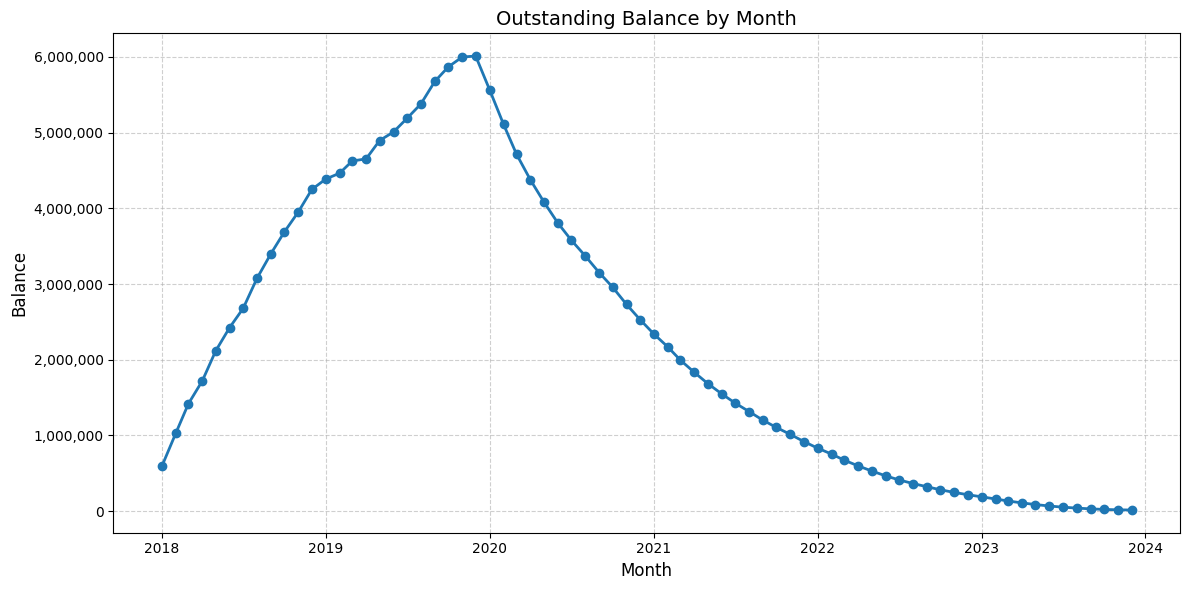

In [ ]:


monthly_agg['period'] = pd.to_datetime(
    monthly_agg[['year','month']].assign(day=1)
)


# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_agg['period'], monthly_agg['balance'], marker='o', linewidth=2)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.title("Outstanding Balance by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Balance", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

1) Year-month with highest monthly default:
   -> 2018-03  default_rate = 0.068966

2) Highest default rate experienced (single month):
   -> 0.068966

3) Mean default rate per annum:
 year  default_rate
 2018      0.042758
 2019      0.034897
 2020      0.024635
 2021      0.012309
 2022      0.007075
 2023      0.005154


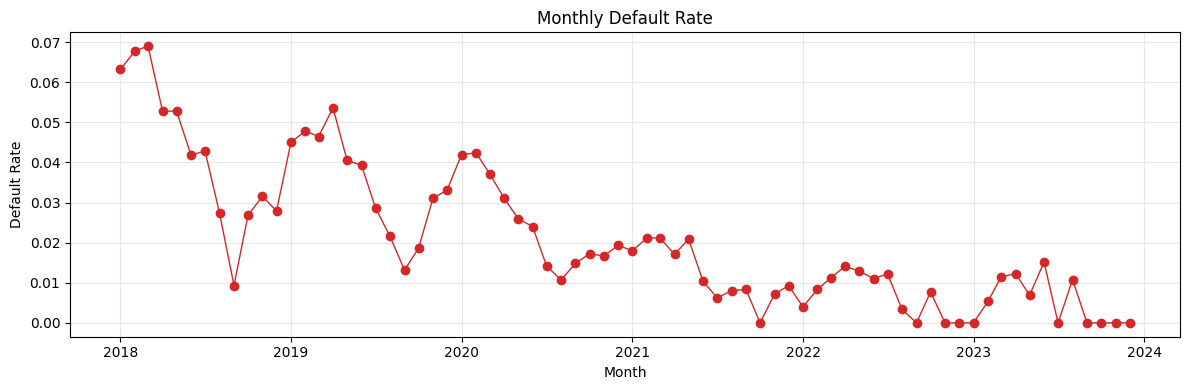

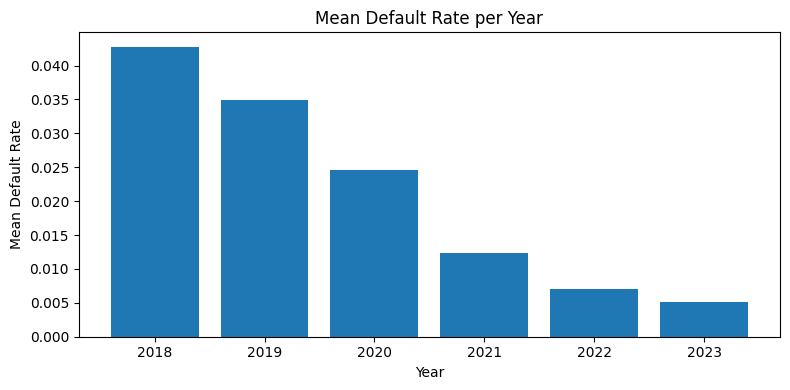

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("portfolio_monthly.csv")
df['date'] = pd.to_datetime(df['date'])
# create monthly aggregation (MS)
monthly = df.groupby(pd.Grouper(key='date', freq='MS')).agg(
    total_balance=('balance','sum'),
    total_chargeoff=('default_flag','sum'),
    total_payment=('payment','sum'),
    total_loan_amount=('loan_amount','sum'),
    active_loans=('loan_id','nunique')
).reset_index().sort_values('date')

# Calculate default rate
monthly['default_rate'] = monthly['total_chargeoff'] / monthly['active_loans']

# --- 1) Find year/month with highest default ---
idx_max = monthly['default_rate'].idxmax()
row_max = monthly.loc[idx_max]
print("1) Year-month with highest monthly default:")
print(f"   -> {row_max['date'].strftime('%Y-%m')}  default_rate = {row_max['default_rate']:.6f}")

# --- 2) Highest default rate experienced (single month) ---
highest_default_rate = monthly['default_rate'].max()
print("\n2) Highest default rate experienced (single month):")
print(f"   -> {highest_default_rate:.6f}")

# --- 3) Mean default rate per annum ---
mean_by_year = monthly.assign(year=monthly['date'].dt.year) \
                      .groupby('year')['default_rate'].mean().reset_index()
print("\n3) Mean default rate per annum:")
print(mean_by_year.to_string(index=False))

# --- Plot 1: Monthly Default Rate ---
plt.figure(figsize=(12,4))
plt.plot(monthly['date'], monthly['default_rate'], marker='o', linewidth=1, color='tab:red')
plt.title("Monthly Default Rate")
plt.xlabel("Month")
plt.ylabel("Default Rate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 2: Mean Default Rate per Year ---
plt.figure(figsize=(8,4))
plt.bar(mean_by_year['year'].astype(str), mean_by_year['default_rate'], color='tab:blue')
plt.title("Mean Default Rate per Year")
plt.xlabel("Year")
plt.ylabel("Mean Default Rate")
plt.tight_layout()
plt.show()


Data range: 2018-01-01 -> 2023-12-01
Training months: 60; Testing months: 12

Searching SARIMA orders (small grid) by AIC. This may take a few moments...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best SARIMA order by AIC: order=(1, 0, 0) seasonal=(0, 0, 0, 12) AIC=-413.55

Fitting final SARIMAX model with exogenous variables...
SARIMAX performance on test window: RMSE = 0.011977, MAPE = 34810718677355.188

Training RandomForest using lag features and exogenous vars...
RandomForest performance on test window: RMSE = 0.005939, MAPE = 11924768430123.781

Model comparison (test window):
 SARIMAX -> RMSE: 0.011977, MAPE: 34810718677355.188
 RandomForest -> RMSE: 0.005939, MAPE: 11924768430123.781


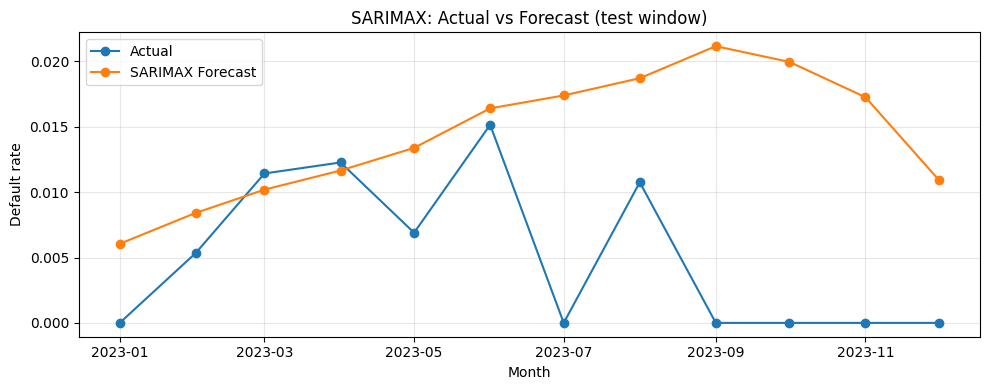

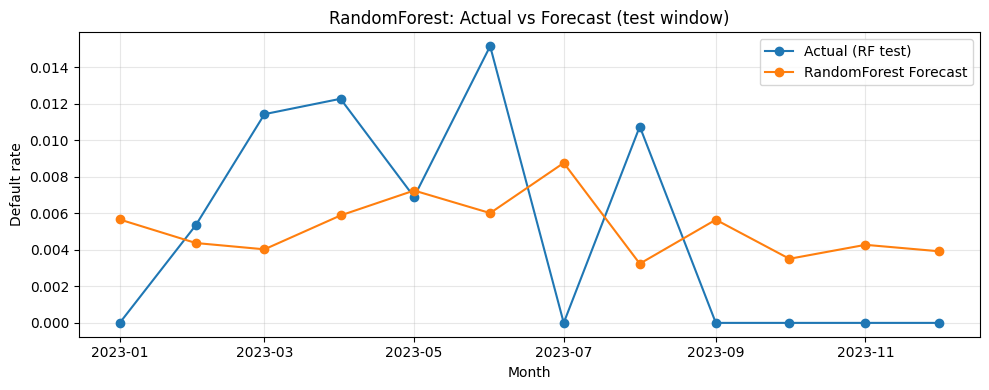


Saved default_forecast_comparison.csv with actual & predictions.

Done. If you want, I can:
 - run auto-ARIMA (pmdarima) instead (if you can install pmdarima),
 - add XGBoost / hyperparameter tuning for RF,
 - produce prediction intervals for RF via quantile forest or bootstrapping.


In [7]:
# Prepare series & train/test split
monthly = pd.read_csv("portfolio_monthly.csv")
monthly['date'] = pd.to_datetime(monthly['date'])
CSV_PATH = "portfolio_monthly.csv"
TEST_MONTHS = 12
LAGS = 6
SARIMA_GRID = {
    'p': [0,1,2],
    'd': [0,1],
    'q': [0,1,2],
    'P': [0,1],
    'D': [0,1],
    'Q': [0,1],
    's': 12
}
series = monthly.set_index('date')['default_rate'].asfreq('MS').fillna(0.0)
# exog matrix - choose a few columns (aligned to index)
exog_vars = ['total_balance','payment_to_balance','active_loans','balance_growth']
exog = monthly.set_index('date')[exog_vars].asfreq('MS').fillna(0.0)

train = series[TEST_MONTHS]
test = series[TEST_MONTHS]
exog_train = exog.loc[train.index]
exog_test = exog.loc[test.index]

print(f"\nData range: {series.index.min().date()} -> {series.index.max().date()}")
print(f"Training months: {len(train)}; Testing months: {len(test)}")

# ---------- 4) SARIMA order grid search (by AIC) ----------
print("\nSearching SARIMA orders (small grid) by AIC. This may take a few moments...")
best_aic = np.inf
best_order = None
best_seasonal = None
s = SARIMA_GRID['s']

# grid
for p in SARIMA_GRID['p']:
    for d in SARIMA_GRID['d']:
        for q in SARIMA_GRID['q']:
            for P in SARIMA_GRID['P']:
                for D in SARIMA_GRID['D']:
                    for Q in SARIMA_GRID['Q']:
                        try:
                            mod = sm.tsa.statespace.SARIMAX(train, order=(p,d,q),
                                                            seasonal_order=(P,D,Q,s),
                                                            enforce_stationarity=False, enforce_invertibility=False)
                            res = mod.fit(disp=False, maxiter=50)
                            if res.aic < best_aic:
                                best_aic = res.aic
                                best_order = (p,d,q)
                                best_seasonal = (P,D,Q,s)
                        except Exception:
                            continue

print(f"Best SARIMA order by AIC: order={best_order} seasonal={best_seasonal} AIC={best_aic:.2f}")

# ---------- 5) Fit SARIMAX (with exogenous variables) ----------
# Use the best order discovered; include exog to attempt improved fit
print("\nFitting final SARIMAX model with exogenous variables...")
sarima_model = sm.tsa.statespace.SARIMAX(train, order=best_order, seasonal_order=best_seasonal,
                                        exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
sarima_res = sarima_model.fit(disp=False)
sarima_pred = sarima_res.get_forecast(steps=len(test), exog=exog_test).predicted_mean
sarima_pred.index = test.index

rmse_sarima = math.sqrt(mean_squared_error(test, sarima_pred))
mape_sarima = mean_absolute_percentage_error(test, sarima_pred)
print(f"SARIMAX performance on test window: RMSE = {rmse_sarima:.6f}, MAPE = {mape_sarima:.3f}")

# ---------- 6) RandomForest with lagged features + exog ----------
print("\nTraining RandomForest using lag features and exogenous vars...")
# build lag features DataFrame for full series
def make_features(series, exog_df, lags=6):
    df_feat = pd.DataFrame({'y': series})
    # lags of target
    for i in range(1, lags+1):
        df_feat[f'y_lag{i}'] = df_feat['y'].shift(i)
    # add exog (current month exog) and also a couple of lagged exogs
    for col in exog_df.columns:
        df_feat[col] = exog_df[col]
        for j in [1]:
            df_feat[f'{col}_lag{j}'] = exog_df[col].shift(j)
    df_feat = df_feat.dropna()
    return df_feat

feat_df = make_features(series, exog, LAGS)
# split train/test on indices
feat_train = feat_df.loc[train.index.intersection(feat_df.index)]
feat_test = feat_df.loc[test.index.intersection(feat_df.index)]

X_train = feat_train.drop(columns='y').values
y_train = feat_train['y'].values
X_test = feat_test.drop(columns='y').values
y_test = feat_test['y'].values

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rmse_rf = math.sqrt(mean_squared_error(y_test, rf_pred))
mape_rf = mean_absolute_percentage_error(y_test, rf_pred)
print(f"RandomForest performance on test window: RMSE = {rmse_rf:.6f}, MAPE = {mape_rf:.3f}")

# ---------- 7) Compare & plot ----------
print("\nModel comparison (test window):")
print(f" SARIMAX -> RMSE: {rmse_sarima:.6f}, MAPE: {mape_sarima:.3f}")
print(f" RandomForest -> RMSE: {rmse_rf:.6f}, MAPE: {mape_rf:.3f}")

# Plot SARIMAX
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, marker='o', label='Actual')
plt.plot(sarima_pred.index, sarima_pred.values, marker='o', label='SARIMAX Forecast')
plt.title("SARIMAX: Actual vs Forecast (test window)")
plt.xlabel("Month")
plt.ylabel("Default rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot RandomForest (align index)
plt.figure(figsize=(10,4))
plt.plot(feat_test.index, feat_test['y'].values, marker='o', label='Actual (RF test)')
plt.plot(feat_test.index, rf_pred, marker='o', label='RandomForest Forecast')
plt.title("RandomForest: Actual vs Forecast (test window)")
plt.xlabel("Month")
plt.ylabel("Default rate")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save outputs
out_df = pd.DataFrame({
    'actual': test,
    'sarimax_pred': sarima_pred.reindex(test.index),
})
# add RF predictions where overlapping
rf_df = pd.Series(index=feat_test.index, data=rf_pred)
out_df = out_df.assign(rf_pred = rf_df.reindex(out_df.index))
out_df.to_csv("default_forecast_comparison.csv", index=True)
print("\nSaved default_forecast_comparison.csv with actual & predictions.")

print("\nDone. If you want, I can:")
print(" - run auto-ARIMA (pmdarima) instead (if you can install pmdarima),")
print(" - add XGBoost / hyperparameter tuning for RF,")
print(" - produce prediction intervals for RF via quantile forest or bootstrapping.")

Valuation date (as_of): 2023-12-01
Active loans at valuation: 26
Computing baseline portfolio PV (deterministic)...
Baseline portfolio PV: 9,396

Running Monte Carlo with 2000 sims (hazard_sd=0.25, rate_sd=0.01) ...


Running MC sims: 100%|██████████| 2000/2000 [00:05<00:00, 341.53it/s]



Monte Carlo results summary:
  Baseline PV: 9,396
  Mean PV (MC): 9,398
  Median PV (MC): 9,397
  5th percentile PV: 9,077
  95th percentile PV: 9,725
  P(PV < baseline) = 49.90%
  P(PV < 90% of baseline) = 0.00%
  CVaR (mean of worst 5%): 8,999


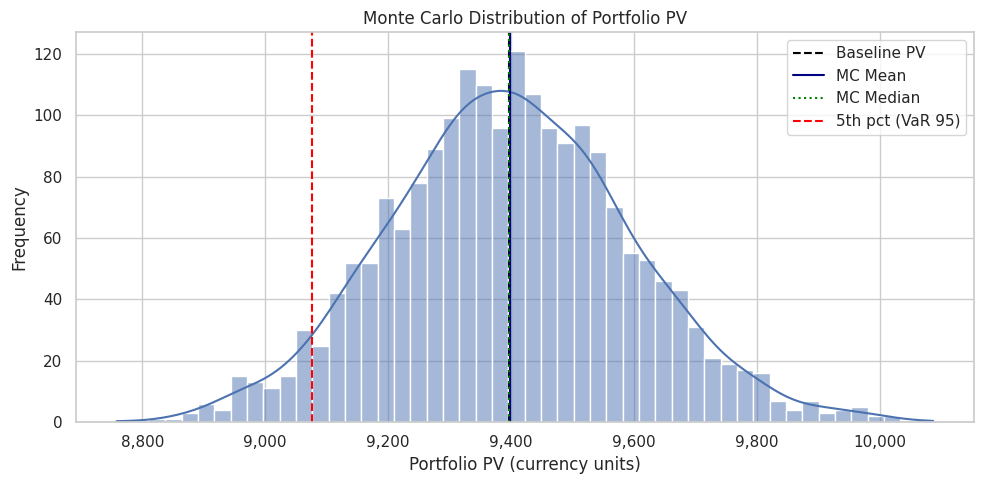

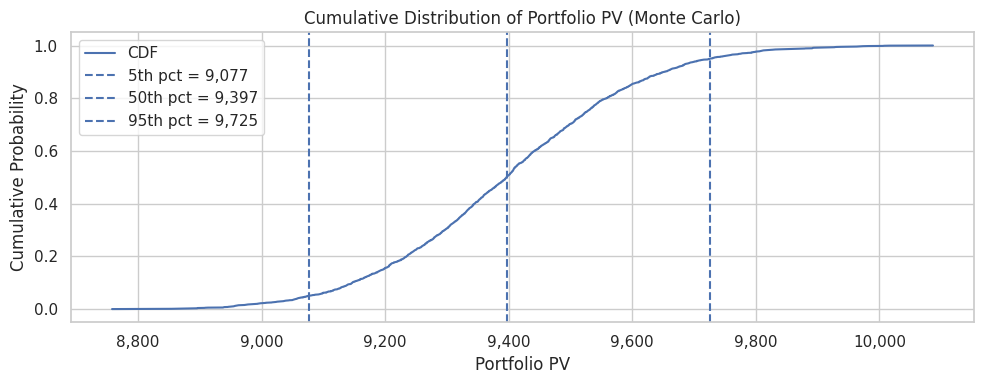


Saved simulation results to mc_portfolio_pv_results.csv


In [11]:
# MonteCarlo_Portfolio_NPV

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ----------------- CONFIG -----------------
CSV_PATH = "portfolio_monthly.csv"
VAL_DATE = None  # if None, will use latest date available in dataset
DISCOUNT_RATE_ANNUAL = 0.06   # used for DCF baseline and sims
N_SIMS = 2000                 # Monte Carlo iterations (increase for stability)
HAZARD_MULTIPLIER_SD = 0.25   # stdev for hazard multiplier (normal around 1)
RATE_SHIFT_SD = 0.01          # stdev for absolute interest rate shift (in decimals, e.g., 0.01 = 1%)
RANDOM_SEED = 42
# ------------------------------------------

np.random.seed(RANDOM_SEED)

# ----------------- Load or generate sample data -----------------

def generate_small_synthetic(path, n_loans=1200):
    # quick synthetic dataset (only minimal fields needed)
    start_date = pd.Timestamp("2020-01-01")
    months = pd.date_range(start_date, periods=60, freq='MS')
    records = []
    for i in range(n_loans):
        loan_id = 200000 + i
        orig = np.random.choice(months)
        term = int(np.random.choice([12,24,36,48,60], p=[0.2,0.25,0.25,0.15,0.15]))
        P = int(np.random.exponential(scale=30000)) + 5000
        credit = int(np.clip(np.random.normal(650, 70), 300, 850))
        base_rate = 0.08 + (700-credit)/2000 + np.random.normal(0, 0.005)
        base_rate = max(0.03, base_rate)
        # monthly payment
        r = base_rate/12.0
        payment = (P * r) / (1 - (1+r)**(-term))
        hazard = np.clip((700-credit)/7000, 0.001, 0.06)
        recovery = np.clip(np.random.normal(0.45, 0.12), 0.1, 0.9)
        # store loan-level single snapshot as of orig (we'll compute remaining schedule later)
        records.append({
            'loan_id': loan_id,
            'origination_date': orig,
            'term_months': term,
            'loan_amount': P,
            'interest_rate': base_rate,  # annual
            'monthly_payment': payment,
            'hazard': hazard,            # monthly hazard (approx)
            'recovery_rate': recovery,
            'age_months': 0,             # we'll compute age for valuation later
            'balance': P
        })
    loans = pd.DataFrame(records)
    loans.to_csv(path, index=False)
    return loans

if not os.path.exists(CSV_PATH):
    print(f"{CSV_PATH} not found — generating a synthetic dataset for demo.")
    generate_small_synthetic(CSV_PATH)

loans = pd.read_csv(CSV_PATH, parse_dates=['origination_date'], infer_datetime_format=True)


# If the file already contains monthly snapshots, take loans as is; otherwise, we'll assume loans are orig-level

# - If file has 'date' and 'balance' columns per-month, we'll aggregate by loan_id at the valuation date.
# - Otherwise, use origination-level snippet and assume valuation at last month (simple approach).
# Ensure date fields are datetime
if 'date' in loans.columns:
    loans['date'] = pd.to_datetime(loans['date'])
if 'origination_date' in loans.columns:
    loans['origination_date'] = pd.to_datetime(loans['origination_date'])


if 'date' in loans.columns and 'balance' in loans.columns and 'loan_id' in loans.columns:
    # dataset already monthly snapshot; pick the latest date snapshot as-of valuation
    if VAL_DATE is None:
        VAL_DATE = loans['date'].max()
    as_of_df = loans[loans['date'] == VAL_DATE].copy()
    # Create age_months column for monthly snapshot data
    if 'origination_date' in as_of_df.columns and 'date' in as_of_df.columns:
        as_of_df['age_months'] = ((as_of_df['date'].dt.year - as_of_df['origination_date'].dt.year) * 12 +
                                  (as_of_df['date'].dt.month - as_of_df['origination_date'].dt.month))
    else:
         raise ValueError("Required date columns not found in monthly snapshot data.")

    # Ensure required columns exist
    needed = ['loan_id','balance','interest_rate','term_months','age_months','payment','default_flag','recovery_rate'] # Include payment, default_flag, and recovery_rate
    for c in needed:
        if c not in as_of_df.columns:
            raise ValueError(f"Expected column '{c}' in monthly snapshot data.")
else:
    # we have orig-level data; create an as_of snapshot at the last month
    if VAL_DATE is None:
        VAL_DATE = loans['origination_date'].max() + pd.DateOffset(months=59)  # assume 5-year window end
    # For each loan, compute remaining term and balance at valuation date by simple amortization formula
    rows = []
    for _, r in loans.iterrows():
        orig = r['origination_date']
        # compute age in months
        age = (VAL_DATE.year - pd.to_datetime(orig).year) * 12 + (VAL_DATE.month - pd.to_datetime(orig).month)
        age = max(0, age)
        term = int(r['term_months'])
        # if loan matured before valuation date, skip
        if age >= term:
            continue
        P = float(r['loan_amount'])
        ann_r = float(r['interest_rate'])
        m_r = ann_r / 12.0
        payment = (P * m_r) / (1 - (1+m_r)**(-term)) if m_r>0 else P/term
        k = age
        # remaining balance formula
        if m_r > 0:
            balance = P * (1+m_r)**k - payment * (((1+m_r)**k - 1)/m_r)
        else:
            balance = max(0.0, P - payment * k)
        rows.append({
            'loan_id': r['loan_id'],
            'balance': balance,
            'interest_rate': r['interest_rate'],
            'term_months': r['term_months'],
            'age_months': age,
            'monthly_payment': payment,
            'hazard': r.get('hazard', 0.01), # Use .get with a default in case hazard isn't in orig data
            'recovery_rate': r.get('recovery_rate', 0.4) # Use .get with a default
        })
    as_of_df = pd.DataFrame(rows)
    if as_of_df.empty:
        raise ValueError("No loans active at valuation date. Check VAL_DATE or data.")

print(f"Valuation date (as_of): {pd.to_datetime(VAL_DATE).date()}")
print(f"Active loans at valuation: {len(as_of_df)}")

# ----------------- Baseline DCF value function -----------------
def expected_pv_of_loan(row, discount_rate_annual=DISCOUNT_RATE_ANNUAL, hazard=None, interest_shift=0.0):
    """Compute expected PV of remaining cashflows for a single loan.
       hazard: monthly hazard override (if None uses row['hazard'])
       interest_shift: absolute shift to annual interest rate (e.g., +0.01 increases 1%)
    """
    rem = int(max(0, row['term_months'] - row['age_months']))
    bal = float(row['balance'])
    ann_rate = float(row['interest_rate']) + interest_shift
    monthly_r = max(0.0, ann_rate / 12.0)
    # Use the 'hazard' column if it exists, otherwise use a default or a column that might represent risk
    hazard_local = row.get('hazard', 0.01) if hazard is None else hazard # Use .get for safety
    recovery = float(row.get('recovery_rate', 0.4)) # Use .get for safety
    monthly_discount = (1 + discount_rate_annual) ** (1/12.0) - 1
    pv = 0.0
    # approximate expected cashflows month by month using survival probabilities
    for t in range(1, rem+1):
        surv_prob = (1 - hazard_local) ** (t-1)
        expected_interest = bal * monthly_r * surv_prob
        # Ensure 'monthly_payment' exists and handle potential missing values
        monthly_payment = row.get('monthly_payment', (bal * monthly_r) / (1 - (1+monthly_r)**(-rem)) if monthly_r > 0 and rem > 0 else bal/rem if rem > 0 else 0.0)
        expected_principal = min(monthly_payment - bal * monthly_r, bal) * surv_prob if monthly_payment > 0 else 0.0

        prob_default_exact = surv_prob * hazard_local
        expected_recovery = prob_default_exact * bal * recovery
        expected_loss = prob_default_exact * bal * (1 - recovery)
        flow = expected_interest + expected_principal + expected_recovery - expected_loss
        # discount
        pv += flow / ((1 + monthly_discount) ** t)
        # reduce balance by expected principal and expected default (approx)
        bal = max(0.0, bal - expected_principal - prob_default_exact * bal)
    return pv

# Compute baseline PV (no shocks)
print("Computing baseline portfolio PV (deterministic)...")
as_of_df['baseline_pv'] = as_of_df.apply(lambda r: expected_pv_of_loan(r, DISCOUNT_RATE_ANNUAL), axis=1)
baseline_portfolio_value = as_of_df['baseline_pv'].sum()
print(f"Baseline portfolio PV: {baseline_portfolio_value:,.0f}")

# ----------------- Monte Carlo simulation -----------------
def run_montecarlo(as_of_df, n_sims=N_SIMS, hazard_sd=HAZARD_MULTIPLIER_SD, rate_sd=RATE_SHIFT_SD, discount_rate=DISCOUNT_RATE_ANNUAL):
    results = np.zeros(n_sims)
    # we'll sample hazard multiplier ~ N(1, hazard_sd) truncated to >0
    for s in tqdm(range(n_sims), desc="Running MC sims"):
        # draw scenario-level shocks
        hazard_mul = np.random.normal(1.0, hazard_sd)    # multiplier applied to each loan hazard
        hazard_mul = max(0.01, hazard_mul)               # floor to avoid zero/neg
        rate_shift = np.random.normal(0.0, rate_sd)      # absolute shift to interest rate (annual)
        # compute PV per loan under scenario
        # vectorized via apply (could be optimized further)
        pv_values = as_of_df.apply(lambda r: expected_pv_of_loan(r, discount_rate_annual=discount_rate,
                                                                hazard=r.get('hazard', 0.01) * hazard_mul, # Use .get here too
                                                                interest_shift=rate_shift), axis=1)
        results[s] = pv_values.sum()
    return results

print(f"\nRunning Monte Carlo with {N_SIMS} sims (hazard_sd={HAZARD_MULTIPLIER_SD}, rate_sd={RATE_SHIFT_SD}) ...")
mc_results = run_montecarlo(as_of_df, n_sims=N_SIMS)

# ----------------- Summary statistics -----------------
mean_mc = mc_results.mean()
median_mc = np.median(mc_results)
p5 = np.percentile(mc_results, 5)
p10 = np.percentile(mc_results, 10)
p90 = np.percentile(mc_results, 90)
p95 = np.percentile(mc_results, 95)
prob_loss = np.mean(mc_results < baseline_portfolio_value)   # chance PV < baseline
prob_10pct_loss = np.mean(mc_results < 0.9 * baseline_portfolio_value)

print("\nMonte Carlo results summary:")
print(f"  Baseline PV: {baseline_portfolio_value:,.0f}")
print(f"  Mean PV (MC): {mean_mc:,.0f}")
print(f"  Median PV (MC): {median_mc:,.0f}")
print(f"  5th percentile PV: {p5:,.0f}")
print(f"  95th percentile PV: {p95:,.0f}")
print(f"  P(PV < baseline) = {prob_loss:.2%}")
print(f"  P(PV < 90% of baseline) = {prob_10pct_loss:.2%}")

# Compute CVaR (Expected Shortfall) at alpha=0.05
alpha = 0.05
losses = np.sort(mc_results)
cvar_5 = losses[:int(len(losses)*alpha)].mean() if int(len(losses)*alpha) > 0 else losses[0]
print(f"  CVaR (mean of worst {int(alpha*100)}%): {cvar_5:,.0f}")

# ----------------- Plots: Histogram + CDF -----------------
plt.figure(figsize=(10,5))
sns.histplot(mc_results, bins=50, kde=True)
plt.axvline(baseline_portfolio_value, color='black', linestyle='--', label='Baseline PV')
plt.axvline(mean_mc, color='navy', linestyle='-', label='MC Mean')
plt.axvline(median_mc, color='green', linestyle=':', label='MC Median')
plt.axvline(p5, color='red', linestyle='--', label='5th pct (VaR 95)')
plt.title("Monte Carlo Distribution of Portfolio PV")
plt.xlabel("Portfolio PV (currency units)")
plt.ylabel("Frequency")
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.tight_layout()
plt.show()

# CDF
plt.figure(figsize=(10,4))
sorted_vals = np.sort(mc_results)
cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
plt.plot(sorted_vals, cdf, label='CDF')
# mark percentiles
for q in [0.05, 0.5, 0.95]:
    val = np.percentile(sorted_vals, q*100)
    plt.axvline(val, linestyle='--', label=f"{int(q*100)}th pct = {val:,.0f}")
plt.title("Cumulative Distribution of Portfolio PV (Monte Carlo)")
plt.xlabel("Portfolio PV")
plt.ylabel("Cumulative Probability")
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.legend()
plt.tight_layout()
plt.show()

# ----------------- Save results -----------------
out_df = pd.DataFrame({'sim_pv': mc_results})
# Correct the output path if needed, based on Colab environment
output_path = "mc_portfolio_pv_results.csv"
out_df.to_csv(output_path, index=False)
print(f"\nSaved simulation results to {output_path}")